# Behavioral Cloning



This is the Project 3 in Self Driving Car Nano degree from Udacity

The purpose of this project is using deep learning to train a deep neural network to drive a car automously in a  simulator.

## Behavioral Cloning Project

The goals / steps of this project are the following:

- Use the simulator to collect data of good driving behavior
- Build a convolution neural network in Keras that predicts steering angles from images
- Train and validate the model with a training and validation set
- Test that the model successfully drives around track one without leaving the road
- Summarize the results with a written report

## Code Scripts

In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn

### Image Augmentation

In [2]:
def flip_image(img, angle):
    """
    Randomly flip the image and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        angle = -angle
    return img, angle


### Reading and spliting data

In [3]:
# Read the driving_log.csv and get paths of images as samples
samples = []
with open('../../P3_Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2, random_state=0)

### Using generator function to compile and train the model 

In [4]:
def select_image(batch_sample, is_training=False):
    """
    Randomly select an image among the center, left or right images, and adjust the steering angle.
    This way, we can teach your model how to steer if the car drifts off to the left or the right.
    """
    if is_training == True:
        choice = np.random.choice(3)
    else:
        choice = 0
        
    name = '../../P3_Data/IMG/'+batch_sample[choice].split('/')[-1]
    image = cv2.imread(name)
    steering_center = float(batch_sample[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    if choice == 0:
        return image, steering_center
    elif choice == 1:
        return image, steering_left
    return image, steering_right

def generator(samples, batch_size=32, is_training=False):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image, angle = select_image(batch_sample, is_training=is_training)
                images.append(image)
                angles.append(angle)

            # Get training data
            X_train = np.array(images)
            y_train = np.array(angles)
            
            # Randomly flip image if in training mode
            if is_training == True:
                X_train_augmented, y_train_augmented = [], []
                for x, y in zip(X_train, y_train):
                    x_augmented, y_augmented = flip_image(x, y)
                    X_train_augmented.append(x_augmented)
                    y_train_augmented.append(y_augmented)

                X_train_augmented = np.array(X_train_augmented)
                y_train_augmented = np.array(y_train_augmented)       

                yield sklearn.utils.shuffle(X_train_augmented, y_train_augmented)
            
            else:
                yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32, is_training=True)
validation_generator = generator(validation_samples, batch_size=32, is_training=False)

### Train the network

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 75, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 75, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

/Users/phuongpham/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1917: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
9653/9653 [==============================] - 145s - loss: 0.0357 - val_loss: 0.0187
Epoch 2/10
9653/9653 [==============================] - 147s - loss: 0.0314 - val_loss: 0.0198
Epoch 3/10
9653/9653 [==============================] - 150s - loss: 0.0299 - val_loss: 0.0184
Epoch 4/10
9653/9653 [==============================] - 146s - loss: 0.0280 - val_loss: 0.0179
Epoch 5/10
9653/9653 [==============================] - 148s - loss: 0.0275 - val_loss: 0.0182
Epoch 6/10
9653/9653 [==============================] - 148s - loss: 0.0270 - val_loss: 0.0176
Epoch 7/10
9653/9653 [==============================] - 153s - loss: 0.0255 - val_loss: 0.0169
Epoch 8/10
9653/9653 [==============================] - 156s - loss: 0.0252 - val_loss: 0.0179
Epoch 9/10
9653/9653 [==============================] - 157s - loss: 0.0245 - val_loss: 0.0170
Epoch 10/10
9653/9653 [==============================] - 155s - loss: 0.0228 - val_loss: 0.0160
dict_keys(['val_loss', 'loss'])


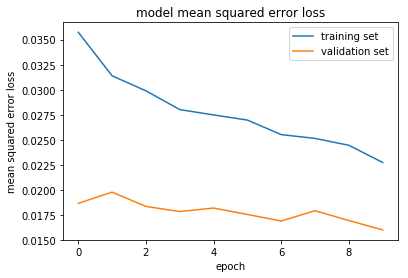

In [5]:
# Build network architecture 
# for a regression network (need only 1 neuron at output)
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.backend import tf as ktf
from keras.callbacks import ModelCheckpoint

row, col, ch = 160, 320, 3  # image format
INPUT_SHAPE = (row,col,ch)

def resize(image):
    from keras.backend import tf as ktf   
    resized = ktf.image.resize_images(image, (66, 200))
    return resized

# Create the Sequential model
model = Sequential()

## Set up lambda layers for data preprocessing: 

# Set up cropping2D layer: cropping (top, bottom) (left, right) pixels 
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=INPUT_SHAPE)) 

# Add Lambda layer for resizing image (image, height, width, data_format)
#model.add(Lambda(resize, input_shape=(75, 320, 3), output_shape=(66, 200, 3)))

# Add Lambda layer for normalization
model.add(Lambda(lambda x: (x / 127.5) - 1.0))

## Build a Multi-layer feedforward neural network with Keras here.

# 1st Layer - Add a convolution layer
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))

# 2nd Layer - Add a convolution layer
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))

# 3rd Layer - Add a convolution layer
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))

# 4th Layer - Add a convolution layer
model.add(Convolution2D(64, 3, 3, activation='relu'))

# 5th Layer - Add a convolution layer
model.add(Convolution2D(64, 3, 3, activation='relu'))

# 6th Layer - Add a convolution layer
model.add(Dropout(0.5))

# 7th Layer - Add a flatten layer
model.add(Flatten())

# 8th Layer - Add a fully connected layer
model.add(Dense(100, activation='relu'))

# 9th Layer - Add a fully connected layer
model.add(Dense(50, activation='relu'))

# 10th Layer - Add a fully connected layer
model.add(Dense(10, activation='relu'))

# 11th Layer - Add a fully connected layer
model.add(Dense(1))

model.summary()

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint('model-{epoch:02d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=False,
                                 mode='auto')
# Compile and train the model
model.compile(optimizer='adam', loss='mse', verbose = 1)
# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7, batch_size=128)
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), \
                                     validation_data=validation_generator, nb_val_samples=len(validation_samples), \
                                     nb_epoch=10, callbacks=[checkpointer], verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Run the network

I run the network on the pre-trained model with the following command:

    python drive.py model1.h5 run1
    
And run the simulator with the Autonomous mode. The output video was recorded with the following command

    python video.py run1 --fps 48

### Output

Video with model without resizing images.

In [1]:
from IPython.display import HTML

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format('run1.mp4'))

Video with model with resizing images.

In [10]:
HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format('run2.mp4'))